# Tutorial for `MDRefine` - 2

In these notebooks we are going to perform several different refinements of MD-generated trajectories by employing the package `MDRefine`. In this way, we believe the usage of `MDRefine` will become clear and easy to emulate for your own case of interest.

We remind you to have a look at our paper https://arxiv.org/pdf/2411.07798 and at the documentation https://www.bussilab.org/doc-MDRefine/MDRefine/index.html.

Required assistance may be opened at https://github.com/bussilab/MDRefine/issues.

In [ ]:
# install matplotlib and other dependencies
!pip install -r requirements.txt

In [1]:
import numpy as np
import jax.numpy as jnp
import pandas
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
# import from parent directory
import sys
sys.path.insert(0, '../')

import MDRefine

print("I will use the MDRefine version installed at", MDRefine.__file__)

I will use the MDRefine version installed at ../MDRefine/__init__.py


In [3]:
from MDRefine import load_data, minimizer, split_dataset, hyper_minimizer, MDRefinement, unwrap_dict


## 4. Ensemble + forward-model refinement

Simultaneous refinement of structural ensembles and forward models (Karplus equations) for RNA oligomers.

In this section, we are going to reproduce part of the results presented in *T. Fröhlking et al., "Simultaneous refinement of molecular dynamics ensembles and forward models using experimental data", J. Chem. Phys. 158, 214120 (2023)* https://pubs.aip.org/aip/jcp/article/158/21/214120/2894410.

In [4]:
%%bash

if [ ! -d "DATA" ]; then
    curl -O https://zenodo.org/records/14956459/files/DATA.zip

    unzip DATA.zip
    rm -r DATA.zip
fi

### a. Load data

In [5]:
infos = {}

# Define global properties, valid for all the systems:
infos['global'] = {}
infos['global']['path_directory'] = 'DATA'
infos['global']['system_names'] = ['AAAA', 'CAAU', 'CCCC', 'GACC', 'UUUU', 'UCAAUC']

# Then, define properties which are specific of each system, like experimental data and observables
# If some properties are the same for all the systems, you can store them just once in infos['global']
infos['global']['g_exp'] = ['backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J', 'NOEs']  # , ('uNOEs', '<')]
infos['global']['forward_qs'] = ['backbone1_gamma', 'backbone2_beta_epsilon','sugar']
infos['global']['obs'] = ['NOEs']  # , 'uNOEs']
infos['global']['forward_coeffs'] = 'original_fm_coeffs'

# Select the stride for the frames
stride = 10  # 00

In [6]:
def forward_model_fun(fm_coeffs, forward_qs, selected_obs = None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = jnp.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2 + fm_coeffs[1]*forward_qs_cos['backbone1_gamma'] + fm_coeffs[2],#}
        'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2 + fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon'] + fm_coeffs[5],
        'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2 + fm_coeffs[7]*forward_qs_cos['sugar'] + fm_coeffs[8]}

    return forward_qs_out

In [7]:
infos['global']['forward_model'] = forward_model_fun

In [8]:
data = load_data(infos, stride=stride)

loading data from directory...
loading  AAAA


loading  CAAU
loading  CCCC
loading  GACC
loading  UUUU
loading  UCAAUC
done


Define the regularization:

\begin{equation}
\begin{split}
R(A,B,C) & = \frac{1}{2\pi}\int_0^{2\pi} d\gamma\,(^3J(\gamma)-^3J_0(\gamma))^2 \\
& = \frac{1}{2\pi} \int_0^{2\pi} d\gamma \, [(A-A_0)\cos^2\gamma+(B-B_0)\cos\gamma+(C-C_0)]^2 \\
& = \frac{3}{8}(A-A_0)^2 + \frac{1}{2}(B-B_0)^2 + (C-C_0)^2 + (A-A_0)(C-C_0)
\end{split}
\end{equation}

which is 1/2 of the regularization proposed in *Simultaneous refinement of molecular dynamics ensembles
and forward models using experimental data* by Thorben Frohlking et al.

In [9]:
def forward_model_regularization(coeffs,coeffs_0):
    regularization = (
    3/8*(coeffs[0]-coeffs_0['A_gamma'])**2+1/2*(coeffs[1]-coeffs_0['B_gamma'])**2+(coeffs[2]-coeffs_0['C_gamma'])**2+(coeffs[0]-coeffs_0['A_gamma'])*(coeffs[2]-coeffs_0['C_gamma'])+
    3/8*(coeffs[3]-coeffs_0['A_beta'])**2+1/2*(coeffs[4]-coeffs_0['B_beta'])**2+(coeffs[5]-coeffs_0['C_beta'])**2+(coeffs[3]-coeffs_0['A_beta'])*(coeffs[5]-coeffs_0['C_beta'])+
    3/8*(coeffs[6]-coeffs_0['A_sugar'])**2+1/2*(coeffs[7]-coeffs_0['B_sugar'])**2+(coeffs[8]-coeffs_0['C_sugar'])**2+(coeffs[6]-coeffs_0['A_sugar'])*(coeffs[8]-coeffs_0['C_sugar']))

    return regularization

In [10]:
regularization = {'force_field_reg': 'KL divergence', 'forward_model_reg': forward_model_regularization}

### b. Minimize

Let's use the `minimizer` function with the optimal hyperparameters $\alpha, \gamma$ determined in the above-mentioned paper, by Thorben Frohlking et al.

In [11]:
opt_alpha = 174.33288
opt_gamma = 3.43332*2

In [12]:
Result = minimizer(data, regularization=regularization, alpha=opt_alpha, gamma=opt_gamma)

References for MDRefine package:
I. Gilardoni, V. Piomponi, T. Fröhlking, and G. Bussi, “MDRefine: a Python package for refining Molecular Dynamics trajectories with experimental data”, arxiv (2024)

References for Ensemble Refinement:
J. W. Pitera and J. D. Chodera, “On the use of experimental observations to bias simulated ensembles”, J. Chem. Theory Comp. 8, 3445–3451 (2012).

G. Hummer and J. Köfinger, “Bayesian ensemble refinement by replica simulations and reweighting”, J. Chem. Phys. 143, 243150 (2015).

A. Cesari, A. Gil-Ley, and G. Bussi, “Combining simulations and solution experiments as a paradigm for RNA force field refinement”, J. Chem. Theory Comp. 12, 6192–6200 (2016).

A. Cesari, S. Reißer, and G. Bussi, “Using the maximum entropy principle to combine simulations and solution experiments”, Computation 6, 15 (2018).

J. Köfinger, L. S. Stelzl, K. Reuter, C. Allande, K. Reichel, and G. Hummer, “Efficient ensemble refinement by reweighting”, J. Chem. Theory Comput. 15, 339

You may save the results in a folder `folder_name` with `save_txt` function of `MDRefine` package.

In [13]:
from MDRefine import save_txt

In [14]:
input_values = {'stride': stride, 'alpha': opt_alpha, 'beta': np.inf, 'gamma': opt_gamma}

coeff_names = data.properties.forward_coeffs_0.index

# input parameters: `input_values` dictionary, `Result` class instance, `coeff_names`, `folder_name`
save_txt(input_values, Result, coeff_names, folder_name='my_result_Karplus')

Let's analyse the results of `minimizer`

In [15]:
print(vars(Result).keys())

print('loss: ', Result.loss)
print('forward-model coefficients: ', Result.pars)
print('KL divergence: ', Result.D_KL_alpha)

dict_keys(['loss', 'pars', 'mini', 'min_lambdas', 'minis', 'intermediates', 'time', 'reg_fm', 'D_KL_alpha', 'abs_difference', 'av_g', 'chi2', 'logZ_new', 'weights_new'])
loss:  263.2999358620523
forward-model coefficients:  [ 9.76315833 -1.82439626 -0.05544103 16.80182399 -5.64933471  0.94026419
  8.65777611 -1.80901063 -0.0357319 ]
KL divergence:  {'AAAA': DeviceArray(0.03837672, dtype=float64), 'CAAU': DeviceArray(0.03221742, dtype=float64), 'CCCC': DeviceArray(0.00936817, dtype=float64), 'GACC': DeviceArray(0.0035901, dtype=float64), 'UUUU': DeviceArray(0.01323911, dtype=float64), 'UCAAUC': DeviceArray(0.04206142, dtype=float64)}


In [16]:
tot_chi2 = np.sum([item2 for item in Result.chi2.values() for item2 in item.values()])
print('1/2 chi^2: ', 1/2*tot_chi2)

print('gamma*R: ', opt_gamma*Result.reg_fm)
print('alpha*D_{KL, tot}: ', opt_alpha*np.sum([l for l in Result.D_KL_alpha.values()]))

print('loss: ', opt_gamma*Result.reg_fm + opt_alpha*np.sum([l for l in Result.D_KL_alpha.values()]) + 1/2*tot_chi2)


1/2 chi^2:  233.33047935280018
gamma*R:  5.762829438251873
alpha*D_{KL, tot}:  24.20663216795417
loss:  263.2999409590062


You can also look at `intermediates` attribute, namely, the intermediate steps of the minimization (function evaluation)

dict_keys(['loss', 'pars', 'lambdas', 'minis'])


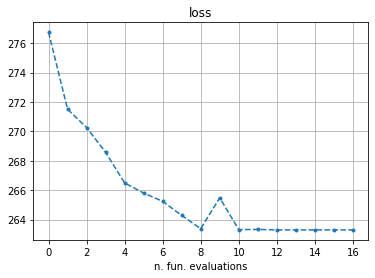

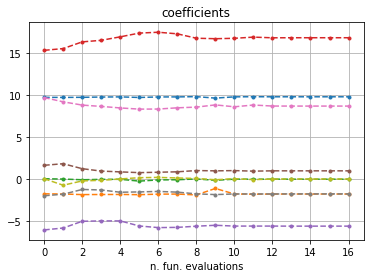

In [17]:
print(vars(Result.intermediates).keys())

plt.plot(Result.intermediates.loss, '.--')
plt.title('loss')
plt.xlabel('n. fun. evaluations')
plt.grid()

plt.figure()

inter_pars = Result.intermediates.pars

for i in range(inter_pars.shape[1]):
    plt.plot(Result.intermediates.pars[:,i], '.--')

plt.title('coefficients')
plt.xlabel('n. fun. evaluations')
plt.grid()

### c. Search for optimal hyperparameters

Let's use `hyper_minimizer` to search for the optimal hyperparameters $\alpha, \gamma$ in cross validation

In [18]:
hyper_search = hyper_minimizer(data, regularization=regularization, starting_alpha=100, starting_gamma=100, random_states=[0])


References for MDRefine package:
I. Gilardoni, V. Piomponi, T. Fröhlking, and G. Bussi, “MDRefine: a Python package for refining Molecular Dynamics trajectories with experimental data”, arxiv (2024)

References for Ensemble Refinement:
J. W. Pitera and J. D. Chodera, “On the use of experimental observations to bias simulated ensembles”, J. Chem. Theory Comp. 8, 3445–3451 (2012).

G. Hummer and J. Köfinger, “Bayesian ensemble refinement by replica simulations and reweighting”, J. Chem. Phys. 143, 243150 (2015).

A. Cesari, A. Gil-Ley, and G. Bussi, “Combining simulations and solution experiments as a paradigm for RNA force field refinement”, J. Chem. Theory Comp. 12, 6192–6200 (2016).

A. Cesari, S. Reißer, and G. Bussi, “Using the maximum entropy principle to combine simulations and solution experiments”, Computation 6, 15 (2018).

J. Köfinger, L. S. Stelzl, K. Reuter, C. Allande, K. Reichel, and G. Hummer, “Efficient ensemble refinement by reweighting”, J. Chem. Theory Comput. 15, 339

## 5. Fully combined refinement

Now, let's include the fitting of a force-field correction term to the previous refinement.

In this way, we are able to combine all the three different refinements (structural ensembles, force-field corrections and forward models) in a single framework. The results so obtained will be compared to those presented in the two papers 

*T. Fröhlking et al., "Simultaneous refinement of molecular dynamics ensembles and forward models using experimental data", J. Chem. Phys. 158, 214120 (2023)* https://pubs.aip.org/aip/jcp/article/158/21/214120/2894410

*I. Gilardoni et al., "Boosting ensemble refinement with transferable force-field corrections: synergistic optimization for molecular simulations", J. Phys. Chem. Letters 15.5 (2024)* https://pubs.acs.org/doi/full/10.1021/acs.jpclett.3c03423,

where ensemble refinement combined with the correction either of the force-field or the forward model is performed.

### a. Load data

take just two molecular systems and exclude the unobserved NOEs to run the script faster

In [19]:
infos = {}

# Define global properties, valid for all the systems:
infos['global'] = {}
infos['global']['path_directory'] = 'DATA'
infos['global']['system_names'] = ['AAAA','CAAU']  # , 'CCCC', 'GACC', 'UUUU', 'UCAAUC']

# Then, define properties which are specific of each system, like experimental data and observables
# If some properties are the same for all the systems, you can store them just once in infos['global']
infos['global']['g_exp'] = ['backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J', 'NOEs']  # , ('uNOEs', '<')]
infos['global']['forward_qs'] = ['backbone1_gamma', 'backbone2_beta_epsilon','sugar']
infos['global']['obs'] = ['NOEs']  # , 'uNOEs']
infos['global']['forward_coeffs'] = 'original_fm_coeffs'

# Select the stride for the frames
stride = 10

In [20]:
def forward_model_fun(fm_coeffs, forward_qs, selected_obs = None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = jnp.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2 + fm_coeffs[1]*forward_qs_cos['backbone1_gamma'] + fm_coeffs[2],
        'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2 + fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon'] + fm_coeffs[5],
        'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2 + fm_coeffs[7]*forward_qs_cos['sugar'] + fm_coeffs[8] }

    return forward_qs_out

In [21]:
infos['global']['forward_model'] = forward_model_fun

In [22]:
infos['global']['names_ff_pars'] = ['sin alpha', 'cos alpha', 'sin zeta', 'cos zeta']

def ff_correction(pars, f):
    out = jnp.matmul(pars, (f[:,[0,6,3,9]]+f[:,[1,7,4,10]]+f[:,[2,8,5,11]]).T)
    return out

def ff_correction_hexamers(pars, f):
    out = jnp.matmul(pars, (f[:,[0,10,5,15]]+f[:,[1,11,6,16]]+f[:,[2,12,7,17]]+f[:,[3,13,8,18]]+f[:,[4,14,9,19]]).T)
    return out

infos['global']['ff_correction'] = ff_correction
infos['UCAAUC'] = {'ff_correction': ff_correction_hexamers}

In [23]:
infos['global']['names_ff_pars'] = ['sin alpha', 'cos alpha']

def ff_correction(pars, f):
    out = jnp.matmul(pars, (f[:, [0, 6]] + f[:, [1, 7]] + f[:, [2, 8]]).T)
    return out

def ff_correction_hexamers(pars, f):
    out = jnp.matmul(pars, (f[:, [0, 10]] + f[:, [1, 11]] + f[:, [2, 12]] + f[:, [3, 13]] + f[:, [4, 14]]).T)
    return out

infos['global']['ff_correction'] = ff_correction
# infos['UCAAUC'] = {'ff_correction': ff_correction_hexamers}

In [24]:
data = load_data(infos, stride=stride)

loading data from directory...
loading  AAAA
loading  CAAU
done


Define the regularizations for the forward-model and the force-field corrections.

In [25]:
def forward_model_regularization(coeffs,coeffs_0):
    regularization = (
    3/8*(coeffs[0]-coeffs_0['A_gamma'])**2 + 1/2*(coeffs[1]-coeffs_0['B_gamma'])**2 + (coeffs[2]-coeffs_0['C_gamma'])**2 + (coeffs[0]-coeffs_0['A_gamma'])*(coeffs[2]-coeffs_0['C_gamma'])+
    3/8*(coeffs[3]-coeffs_0['A_beta'])**2 + 1/2*(coeffs[4]-coeffs_0['B_beta'])**2 + (coeffs[5]-coeffs_0['C_beta'])**2 + (coeffs[3]-coeffs_0['A_beta'])*(coeffs[5]-coeffs_0['C_beta'])+
    3/8*(coeffs[6]-coeffs_0['A_sugar'])**2 + 1/2*(coeffs[7]-coeffs_0['B_sugar'])**2 + (coeffs[8]-coeffs_0['C_sugar'])**2 + (coeffs[6]-coeffs_0['A_sugar'])*(coeffs[8]-coeffs_0['C_sugar']))

    return regularization

In [26]:
regularization = {'force_field_reg': 'KL divergence', 'forward_model_reg': forward_model_regularization}

### b. Minimize

Let's minimize the loss function with `minimizer` and optimal hyperparameters determined by calculations performed on the cluster and reported in our final paper https://arxiv.org/pdf/2411.07798.

In [27]:
alpha = 959.86
beta = 167.94
gamma = 0.42

In [28]:
Result = minimizer(data, regularization=regularization, alpha=alpha, beta=beta, gamma=gamma)

References for MDRefine package:
I. Gilardoni, V. Piomponi, T. Fröhlking, and G. Bussi, “MDRefine: a Python package for refining Molecular Dynamics trajectories with experimental data”, arxiv (2024)

References for Ensemble Refinement:
J. W. Pitera and J. D. Chodera, “On the use of experimental observations to bias simulated ensembles”, J. Chem. Theory Comp. 8, 3445–3451 (2012).

G. Hummer and J. Köfinger, “Bayesian ensemble refinement by replica simulations and reweighting”, J. Chem. Phys. 143, 243150 (2015).

A. Cesari, A. Gil-Ley, and G. Bussi, “Combining simulations and solution experiments as a paradigm for RNA force field refinement”, J. Chem. Theory Comp. 12, 6192–6200 (2016).

A. Cesari, S. Reißer, and G. Bussi, “Using the maximum entropy principle to combine simulations and solution experiments”, Computation 6, 15 (2018).

J. Köfinger, L. S. Stelzl, K. Reuter, C. Allande, K. Reichel, and G. Hummer, “Efficient ensemble refinement by reweighting”, J. Chem. Theory Comput. 15, 339

In [29]:
vars(Result).keys()

dict_keys(['loss', 'pars', 'mini', 'min_lambdas', 'minis', 'intermediates', 'time', 'weights_P', 'logZ_P', 'reg_ff', 'reg_fm', 'D_KL_alpha', 'abs_difference', 'av_g', 'chi2', 'logZ_new', 'weights_new'])

In [30]:
Result.pars

array([ 3.36471872e-02, -2.78242382e-02,  9.99017990e+00, -1.87785192e+00,
       -1.93457562e-01,  1.88330832e+01, -5.13054254e+00, -1.67130664e-02,
        8.77027573e+00, -1.35361426e+00, -5.26772457e-01])

In [31]:
Result.mini

      fun: 87.38464599982478
 hess_inv: array([[ 1.19434789e-03, -1.41244001e-05, -7.94284227e-04,
        -2.22775861e-04,  5.81216020e-04,  3.30030222e-03,
        -1.00702430e-04, -1.46952058e-03, -2.98056939e-03,
        -7.82624624e-05,  1.77122860e-03],
       [-1.41244001e-05,  7.15076585e-03, -9.25153349e-04,
        -3.72559731e-04,  4.57911826e-04,  9.74207181e-03,
        -1.68924187e-03, -4.10480608e-03, -1.16903233e-02,
        -1.17862924e-03,  6.38223538e-03],
       [-7.94284227e-04, -9.25153349e-04,  6.67307419e+00,
         1.02572580e+00, -2.60209794e+00,  4.81018941e-01,
        -5.71290003e-02, -2.02602816e-01, -4.47836797e-01,
        -3.79425680e-02,  2.88842681e-01],
       [-2.22775861e-04, -3.72559731e-04,  1.02572580e+00,
         1.09032539e+00, -7.84211642e-01, -7.01044892e-02,
        -3.99182164e-02,  6.79393398e-02,  1.48244624e-01,
         1.20904294e-03, -8.79875426e-02],
       [ 5.81216020e-04,  4.57911826e-04, -2.60209794e+00,
        -7.84211642e-

In [32]:
vars(Result.intermediates).keys()

dict_keys(['loss', 'pars', 'lambdas', 'minis'])

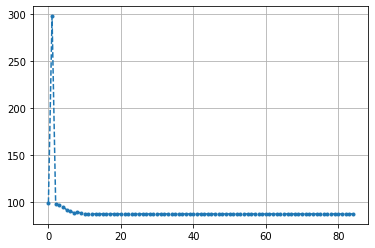

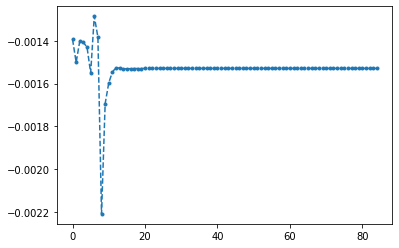

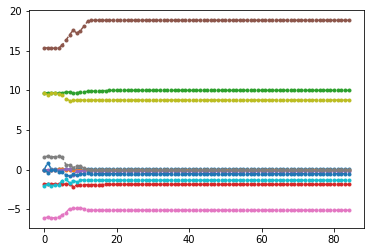

In [33]:
inter_loss = Result.intermediates.loss
plt.plot(inter_loss, '.--')
plt.grid()

plt.figure()

inter_lambdas = np.array(Result.intermediates.lambdas)
plt.plot(inter_lambdas[:,0], '.--')

plt.figure()
plt.plot(Result.intermediates.pars, '.--')
plt.show()

### c. Determine optimal hyper-parameters through cross validation

Scan over the hyperparameters: now we are in a 3-dimensional space, so the calculations are cumbersome.

Let's split the data set into training and validation set just once (with `split_dataset`) and then minimize the loss function with `minimizer` with several values of the hyperparameters (scan in logarithmic scale).

In [34]:
data_train, data_valid, valid_obs, valid_frames = split_dataset(data, random_state=1)

Input random_state employed both for valid_obs and valid_frames


In [35]:
delta = 2.0

log10_alphas = np.arange(-2, 2 + delta, delta)
log10_betas = np.array([-2.0, 0.0, 2.0])
log10_gammas = log10_alphas

Results = {}

for log10_alpha in log10_alphas:
    Results[log10_alpha] = {}

    for log10_beta in log10_betas:
        Results[log10_alpha][log10_beta] = {}
    
        for log10_gamma in log10_gammas:
            print(log10_alpha, log10_beta, log10_gamma)
    
            Results[log10_alpha][log10_beta][log10_gamma] = minimizer(data_train, regularization=regularization, alpha=10**log10_alpha, beta=10**log10_beta, gamma=10**log10_gamma, data_valid=data_valid)

            clear_output()

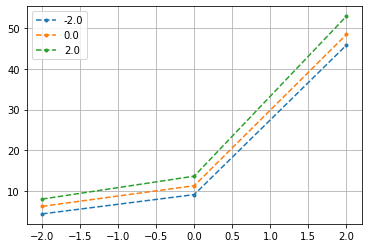

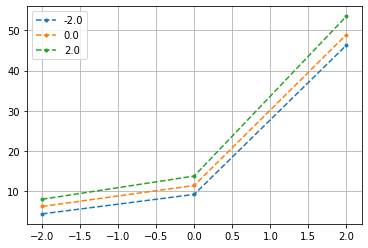

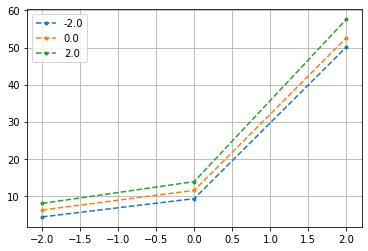

In [36]:
for log10_beta in log10_betas:

    plt.figure()

    for log10_gamma in log10_gammas:
        loss = np.array([Results[log10_alpha][log10_beta][log10_gamma].loss for log10_alpha in log10_alphas])
        plt.plot(log10_alphas, loss, '.--', label=log10_gamma)

    plt.legend()
    plt.grid()

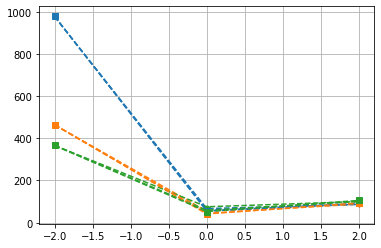

In [37]:
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink', 'tab:gray','tab:olive','tab:cyan']
markers = ['.','v','s','*','D','o','^','<','>','p','P','+','X','d']

for i,log10_beta in enumerate(log10_betas):

    # plt.figure()

    for j,log10_gamma in enumerate(log10_gammas):
        chi2 = np.array([np.sum(unwrap_dict(Results[log10_alpha][log10_beta][log10_gamma].chi2)) for log10_alpha in log10_alphas])
        chi2_valid = np.array([np.sum(unwrap_dict(Results[log10_alpha][log10_beta][log10_gamma].chi2_valid)) for log10_alpha in log10_alphas])
        chi2_new_obs = np.array([np.sum(unwrap_dict(Results[log10_alpha][log10_beta][log10_gamma].chi2_new_obs)) for log10_alpha in log10_alphas])

        loss = np.array([Results[log10_alpha][log10_beta][log10_gamma].loss for log10_alpha in log10_alphas])
        
        # plt.plot(log10_alphas, loss, markers[i] + '--', color = colors[j], label = log10_gamma)
        # plt.plot(log10_alphas, chi2, markers[i] + '--', color = colors[j], label = log10_gamma)
        plt.plot(log10_alphas, chi2_valid, markers[i] + '--', color = colors[j], label = log10_gamma)
        # plt.plot(log10_alphas, chi2_new_obs, markers[i] + '--', color = colors[j], label = log10_gamma)

    # plt.legend()
    plt.grid()

### d. automatic optimization of hyper parameters

In [38]:
hyper_out = hyper_minimizer(data, regularization=regularization, starting_alpha=10**1.3, starting_beta=10**-2.2, starting_gamma=10**-3.5, random_states=2)


References for MDRefine package:
I. Gilardoni, V. Piomponi, T. Fröhlking, and G. Bussi, “MDRefine: a Python package for refining Molecular Dynamics trajectories with experimental data”, arxiv (2024)

References for Ensemble Refinement:
J. W. Pitera and J. D. Chodera, “On the use of experimental observations to bias simulated ensembles”, J. Chem. Theory Comp. 8, 3445–3451 (2012).

G. Hummer and J. Köfinger, “Bayesian ensemble refinement by replica simulations and reweighting”, J. Chem. Phys. 143, 243150 (2015).

A. Cesari, A. Gil-Ley, and G. Bussi, “Combining simulations and solution experiments as a paradigm for RNA force field refinement”, J. Chem. Theory Comp. 12, 6192–6200 (2016).

A. Cesari, S. Reißer, and G. Bussi, “Using the maximum entropy principle to combine simulations and solution experiments”, Computation 6, 15 (2018).

J. Köfinger, L. S. Stelzl, K. Reuter, C. Allande, K. Reichel, and G. Hummer, “Efficient ensemble refinement by reweighting”, J. Chem. Theory Comput. 15, 339

In [39]:
alpha, beta, gamma = 10**hyper_out.x

Result = minimizer(data, regularization=regularization, alpha=alpha, beta=beta, gamma=gamma)

References for MDRefine package:
I. Gilardoni, V. Piomponi, T. Fröhlking, and G. Bussi, “MDRefine: a Python package for refining Molecular Dynamics trajectories with experimental data”, arxiv (2024)

References for Ensemble Refinement:
J. W. Pitera and J. D. Chodera, “On the use of experimental observations to bias simulated ensembles”, J. Chem. Theory Comp. 8, 3445–3451 (2012).

G. Hummer and J. Köfinger, “Bayesian ensemble refinement by replica simulations and reweighting”, J. Chem. Phys. 143, 243150 (2015).

A. Cesari, A. Gil-Ley, and G. Bussi, “Combining simulations and solution experiments as a paradigm for RNA force field refinement”, J. Chem. Theory Comp. 12, 6192–6200 (2016).

A. Cesari, S. Reißer, and G. Bussi, “Using the maximum entropy principle to combine simulations and solution experiments”, Computation 6, 15 (2018).

J. Köfinger, L. S. Stelzl, K. Reuter, C. Allande, K. Reichel, and G. Hummer, “Efficient ensemble refinement by reweighting”, J. Chem. Theory Comput. 15, 339

In [40]:
out = MDRefinement(infos, regularization=regularization, stride=stride, starting_alpha=10**1.3, starting_beta=10**-2.2, starting_gamma=10**-3.5, random_states=2, results_folder_name='../../my_results')

loading data from directory...
loading  AAAA
loading  CAAU
done
References for MDRefine package:
I. Gilardoni, V. Piomponi, T. Fröhlking, and G. Bussi, “MDRefine: a Python package for refining Molecular Dynamics trajectories with experimental data”, arxiv (2024)

References for Ensemble Refinement:
J. W. Pitera and J. D. Chodera, “On the use of experimental observations to bias simulated ensembles”, J. Chem. Theory Comp. 8, 3445–3451 (2012).

G. Hummer and J. Köfinger, “Bayesian ensemble refinement by replica simulations and reweighting”, J. Chem. Phys. 143, 243150 (2015).

A. Cesari, A. Gil-Ley, and G. Bussi, “Combining simulations and solution experiments as a paradigm for RNA force field refinement”, J. Chem. Theory Comp. 12, 6192–6200 (2016).

A. Cesari, S. Reißer, and G. Bussi, “Using the maximum entropy principle to combine simulations and solution experiments”, Computation 6, 15 (2018).

J. Köfinger, L. S. Stelzl, K. Reuter, C. Allande, K. Reichel, and G. Hummer, “Efficient ense

In [41]:
vars(hyper_out.intermediate)

{'av_chi2': DeviceArray([  53.22321384, 1408.16101405,   53.12291703], dtype=float64),
 'av_gradient': DeviceArray([[ 7.91389810e+00,  8.90222368e-03, -6.26233436e-03],
              [-3.80468343e+03,  2.18875007e+01, -6.94000526e+02],
              [ 5.03074973e+00,  1.03531658e-02,  6.04958570e-03]],            dtype=float64),
 'log10_hyperpars': DeviceArray([[ 1.3       , -2.2       , -3.5       ],
              [ 0.30000095, -2.20112488, -3.49920869],
              [ 1.29191268, -2.2000091 , -3.4999936 ]], dtype=float64)}

if you do not specify some hyper parameters, as for example $\gamma$, you are fixing it to $+\infty$ (no refinement in that "direction")

In [42]:
hyper_out = hyper_minimizer(data, regularization=regularization, starting_alpha=0.1, starting_beta=10, random_states=2, gtol=0.1)


References for MDRefine package:
I. Gilardoni, V. Piomponi, T. Fröhlking, and G. Bussi, “MDRefine: a Python package for refining Molecular Dynamics trajectories with experimental data”, arxiv (2024)

References for Ensemble Refinement:
J. W. Pitera and J. D. Chodera, “On the use of experimental observations to bias simulated ensembles”, J. Chem. Theory Comp. 8, 3445–3451 (2012).

G. Hummer and J. Köfinger, “Bayesian ensemble refinement by replica simulations and reweighting”, J. Chem. Phys. 143, 243150 (2015).

A. Cesari, A. Gil-Ley, and G. Bussi, “Combining simulations and solution experiments as a paradigm for RNA force field refinement”, J. Chem. Theory Comp. 12, 6192–6200 (2016).

A. Cesari, S. Reißer, and G. Bussi, “Using the maximum entropy principle to combine simulations and solution experiments”, Computation 6, 15 (2018).

J. Köfinger, L. S. Stelzl, K. Reuter, C. Allande, K. Reichel, and G. Hummer, “Efficient ensemble refinement by reweighting”, J. Chem. Theory Comput. 15, 339

In [43]:
vars(hyper_out.intermediate)

{'av_chi2': DeviceArray([3927.45462687, 3519.9669561 ,  156.03279941,  153.65284427],            dtype=float64),
 'av_gradient': DeviceArray([[-4.13434864e+01, -1.98206475e-03],
              [-2.31002221e+02,  7.62857534e+00],
              [ 3.08147378e+00,  1.23916538e+01],
              [ 3.45160205e+00, -7.37093175e-01]], dtype=float64),
 'log10_hyperpars': DeviceArray([[-1.00000000e+00,  1.00000000e+00],
              [-1.14918886e-09,  1.00004794e+00],
              [ 3.99999999e+00,  1.00023971e+00],
              [ 3.98906090e+00, -2.03956590e-01]], dtype=float64)}